# Importy

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D,MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, SpatialDropout1D, Attention, Concatenate, Layer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tqdm import tqdm
import tensorflow as tf
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler

In [2]:
# Wypakowanie zipa RIP przesylal sie 8 godzin
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/Magisterka/glove.42B.300d.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/Magisterka/")

# Pre-processing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Studia/Magisterka/for_training_songs_data.csv")

In [5]:
def prepare_data(df, column_name):
    texts = df[column_name].astype(str).tolist()  # Convert to string in case any NaN values
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    vocab_size = len(tokenizer.word_index) + 1

    max_sequence_length = 512


    X = pad_sequences(sequences, maxlen=max_sequence_length)
    return X, vocab_size, max_sequence_length, tokenizer.word_index

# Prepare data for each version
X_lemmatized, vocab_size_lemmatized, max_sequence_length_lemmatized, word_index_lemmatized = prepare_data(df, 'Lyric_Lemmatized')
X_stemmed, vocab_size_stemmed, max_sequence_length_stemmed, word_index_stemmed = prepare_data(df, 'Lyric_Stemmed')
X_lemmatized_no_stopwords, vocab_size_no_stopwords, max_sequence_length_no_stopwords, word_index_no_stopwords = prepare_data(df, 'Lyric_Lemmatized_NoStop')


LABEL_COLUMNS = ['Country', 'HipHop', 'Indie', 'Jazz', 'HeavyMetal', 'Rock', 'Pop', 'Rap']
y = df[LABEL_COLUMNS].values


In [6]:
max_sequence_length_no_stopwords

512

In [7]:
def load_glove_embeddings(filepath, word_index, embedding_dim=300):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


embedding_dim = 300

# Load GloVe embeddings
glove_filepath = '/content/drive/MyDrive/Studia/Magisterka/glove.42B.300d.txt'
embedding_matrix_lemmatized = load_glove_embeddings(glove_filepath, word_index_lemmatized, embedding_dim)
embedding_matrix_stemmed = load_glove_embeddings(glove_filepath, word_index_stemmed, embedding_dim)
embedding_matrix_lemmatized_no_stopwords = load_glove_embeddings(glove_filepath, word_index_no_stopwords, embedding_dim)


In [51]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

In [86]:
# Define LSTM model
def create_lstm_model(input_dim, max_seq_len, embedding_dim, embedding_matrix, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim, embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    #COnvolutional block
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))  # Conv1D layer with 256 filters and kernel size 5
    model.add(MaxPooling1D(pool_size=2))


    # First BiLSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=True)))  # BiLSTM layer with 64 units and return sequences
    model.add(Dropout(0.5))  # Dropout after BiLSTM layer

    # Second BiLSTM layer
    model.add(Bidirectional(LSTM(32)))  # BiLSTM layer with 32 units
    model.add(Dropout(0.5))  # Dropout after BiLSTM layer

    # Fully connected layer
    model.add(Dense(64, activation='relu'))  # Fully connected layer with 256 units
    model.add(Dropout(0.5))  # Dropout after fully connected layer

    # Output layer
    model.add(Dense(len(LABEL_COLUMNS), activation='sigmoid'))   # Output layer for multi-label classification with sigmoid activation

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # embedding_dim = 300
    # filters = 128
    # kernel_size = 5
    # lstm_units = 64
    # dense_units = 256
    # dropout_rate = 0.5

    # input_layer = Input(shape=(max_seq_len,))
    # embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False)(input_layer)

    # conv_layer = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(embedding_layer)
    # maxpool_layer = MaxPooling1D(pool_size=2)(conv_layer)

    # bilstm_layer_1 = Bidirectional(LSTM(lstm_units, return_sequences=True))(maxpool_layer)
    # dropout_layer_1 = Dropout(dropout_rate)(bilstm_layer_1)
    # bilstm_layer_2 = Bidirectional(LSTM(lstm_units, return_sequences=True))(dropout_layer_1)
    # dropout_layer_2 = Dropout(dropout_rate)(bilstm_layer_2)

    # attention_layer = AttentionLayer()(dropout_layer_2)

    # dense_layer = Dense(dense_units, activation='relu')(attention_layer)
    # dropout_layer_3 = Dropout(dropout_rate)(dense_layer)

    # output_layer = Dense(len(LABEL_COLUMNS), activation='sigmoid')(dropout_layer_3)

    # model = Model(inputs=input_layer, outputs=output_layer)

    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    return model



# Initialize models for each version
model_lemmatized = create_lstm_model(vocab_size_lemmatized, max_sequence_length_lemmatized, embedding_dim, embedding_matrix_lemmatized, vocab_size_lemmatized)
model_stemmed = create_lstm_model(vocab_size_stemmed, max_sequence_length_stemmed, embedding_dim, embedding_matrix_stemmed, vocab_size_stemmed)
model_lemmatized_no_stopwords = create_lstm_model(vocab_size_no_stopwords, max_sequence_length_no_stopwords, embedding_dim, embedding_matrix_lemmatized_no_stopwords, vocab_size_no_stopwords)


In [87]:
model_lemmatized.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (None, 512, 300)          65152800  
                                                                 
 conv1d_57 (Conv1D)          (None, 510, 64)           57664     
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 255, 64)           0         
 ng1D)                                                           
                                                                 
 bidirectional_77 (Bidirect  (None, 255, 128)          66048     
 ional)                                                          
                                                                 
 dropout_114 (Dropout)       (None, 255, 128)          0         
                                                                 
 bidirectional_78 (Bidirect  (None, 64)              

In [88]:
# Define evaluation metrics function
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y, y_pred_binary)
    precision = precision_score(y, y_pred_binary, average='micro')
    recall = recall_score(y, y_pred_binary, average='micro')
    f1 = f1_score(y, y_pred_binary, average='micro')
    return accuracy, precision, recall, f1


In [44]:
def lr_schedule(epoch):
    """Learning Rate Schedule"""
    if epoch > 3:
        return 0.0005
    if epoch > 6:
        return 0.0001
    else:
        return 0.001

In [85]:
def plot_training_history(history, metric_name):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[metric_name], label=f'Training {metric_name}')
    plt.plot(history.history[f'val_{metric_name}'], label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'Training and Validation {metric_name}')
    plt.legend()
    plt.show()

In [89]:
epochs = 10
batch_size = 128

# Split into train, validation, and test sets
X_train_lemmatized, X_temp_lemmatized, y_train, y_temp = train_test_split(X_lemmatized, y, test_size=0.2, random_state=42)
X_val_lemmatized, X_test_lemmatized, y_val, y_test = train_test_split(X_temp_lemmatized, y_temp, test_size=0.5, random_state=42)

X_train_stemmed, X_temp_stemmed, y_train, y_temp = train_test_split(X_stemmed, y, test_size=0.2, random_state=42)
X_val_stemmed, X_test_stemmed, y_val, y_test = train_test_split(X_temp_stemmed, y_temp, test_size=0.5, random_state=42)

X_train_lemmatized_no_stopwords, X_temp_lemmatized_no_stopwords, y_train, y_temp = train_test_split(X_lemmatized_no_stopwords, y, test_size=0.2, random_state=42)
X_val_lemmatized_no_stopwords, X_test_lemmatized_no_stopwords, y_val, y_test = train_test_split(X_temp_lemmatized_no_stopwords, y_temp, test_size=0.5, random_state=42)

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train models
print("Training models...")
with tqdm(total=3) as pbar:
    history_lemmatized = model_lemmatized.fit(X_train_lemmatized, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_lemmatized, y_val), callbacks=[lr_scheduler, EarlyStopping(patience=3, restore_best_weights=True)])
    pbar.update(1)
    history_stemmed = model_stemmed.fit(X_train_stemmed, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_stemmed, y_val), callbacks=[lr_scheduler, EarlyStopping(patience=3, restore_best_weights=True)])
    pbar.update(1)
    history_lemmatized_no_stopwords = model_lemmatized_no_stopwords.fit(X_train_lemmatized_no_stopwords, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_lemmatized_no_stopwords, y_val), callbacks=[lr_scheduler, EarlyStopping(patience=3, restore_best_weights=True)])
    pbar.update(1)



Training models...


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10
833/833 [==============================] - 48s 51ms/step - loss: 0.3721 - accuracy: 0.3521 - val_loss: 0.2953 - val_accuracy: 0.5074 - lr: 0.0010
Epoch 2/10
833/833 [==============================] - 40s 48ms/step - loss: 0.3103 - accuracy: 0.4910 - val_loss: 0.2824 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 3/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2950 - accuracy: 0.5307 - val_loss: 0.2725 - val_accuracy: 0.5678 - lr: 0.0010
Epoch 4/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2846 - accuracy: 0.5539 - val_loss: 0.2731 - val_accuracy: 0.5668 - lr: 0.0010
Epoch 5/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2727 - accuracy: 0.5803 - val_loss: 0.2624 - val_accuracy: 0.5879 - lr: 5.0000e-04
Epoch 6/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2664 - accuracy: 0.5930 - val_loss: 0.2584 - val_accuracy: 0.5938 - lr: 5.0000e-04
Epoch 7/10
833/833 [==============================

 33%|███▎      | 1/3 [06:07<12:15, 367.79s/it]

Epoch 1/10
833/833 [==============================] - 47s 50ms/step - loss: 0.3859 - accuracy: 0.3341 - val_loss: 0.3076 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 2/10
833/833 [==============================] - 40s 48ms/step - loss: 0.3175 - accuracy: 0.4843 - val_loss: 0.2957 - val_accuracy: 0.5335 - lr: 0.0010
Epoch 3/10
833/833 [==============================] - 40s 48ms/step - loss: 0.3019 - accuracy: 0.5132 - val_loss: 0.2812 - val_accuracy: 0.5422 - lr: 0.0010
Epoch 4/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2917 - accuracy: 0.5347 - val_loss: 0.2754 - val_accuracy: 0.5345 - lr: 0.0010
Epoch 5/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2808 - accuracy: 0.5603 - val_loss: 0.2706 - val_accuracy: 0.5656 - lr: 5.0000e-04
Epoch 6/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2746 - accuracy: 0.5739 - val_loss: 0.2678 - val_accuracy: 0.5870 - lr: 5.0000e-04
Epoch 7/10
833/833 [==============================

 67%|██████▋   | 2/3 [12:55<06:31, 391.52s/it]

Epoch 1/10
833/833 [==============================] - 48s 50ms/step - loss: 0.3739 - accuracy: 0.3620 - val_loss: 0.3018 - val_accuracy: 0.4976 - lr: 0.0010
Epoch 2/10
833/833 [==============================] - 40s 48ms/step - loss: 0.3144 - accuracy: 0.4719 - val_loss: 0.2891 - val_accuracy: 0.4756 - lr: 0.0010
Epoch 3/10
833/833 [==============================] - 40s 48ms/step - loss: 0.3002 - accuracy: 0.4905 - val_loss: 0.2782 - val_accuracy: 0.5163 - lr: 0.0010
Epoch 4/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2898 - accuracy: 0.5175 - val_loss: 0.2726 - val_accuracy: 0.5154 - lr: 0.0010
Epoch 5/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2768 - accuracy: 0.5462 - val_loss: 0.2656 - val_accuracy: 0.5776 - lr: 5.0000e-04
Epoch 6/10
833/833 [==============================] - 40s 48ms/step - loss: 0.2706 - accuracy: 0.5583 - val_loss: 0.2627 - val_accuracy: 0.5387 - lr: 5.0000e-04
Epoch 7/10
833/833 [==============================

100%|██████████| 3/3 [19:43<00:00, 394.40s/it]


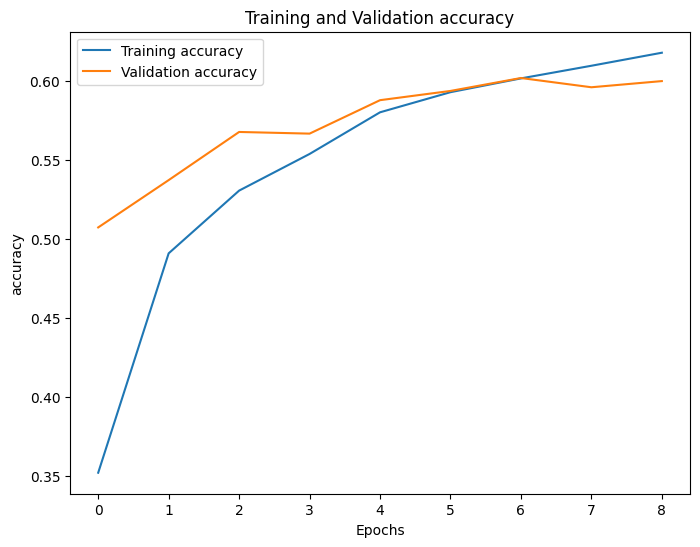

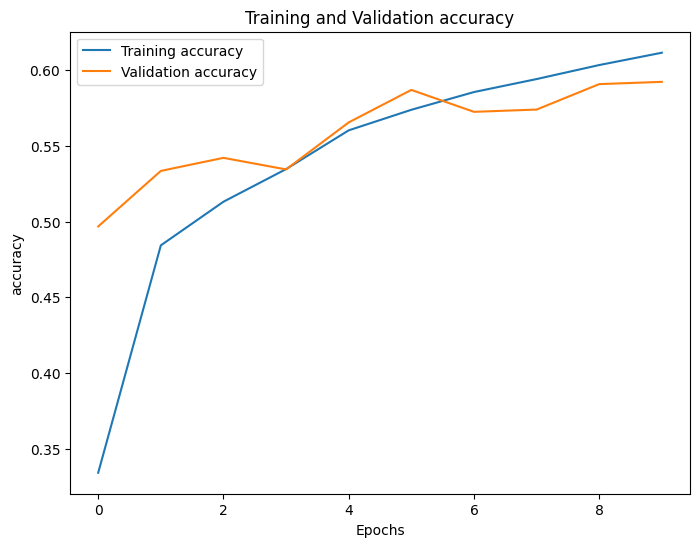

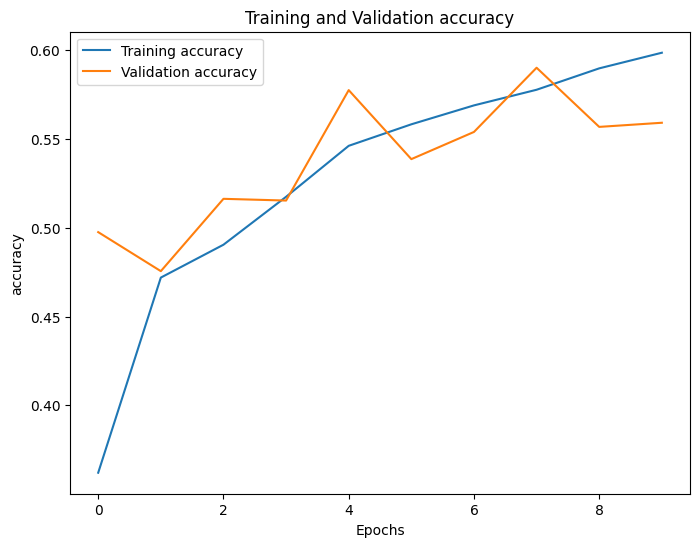

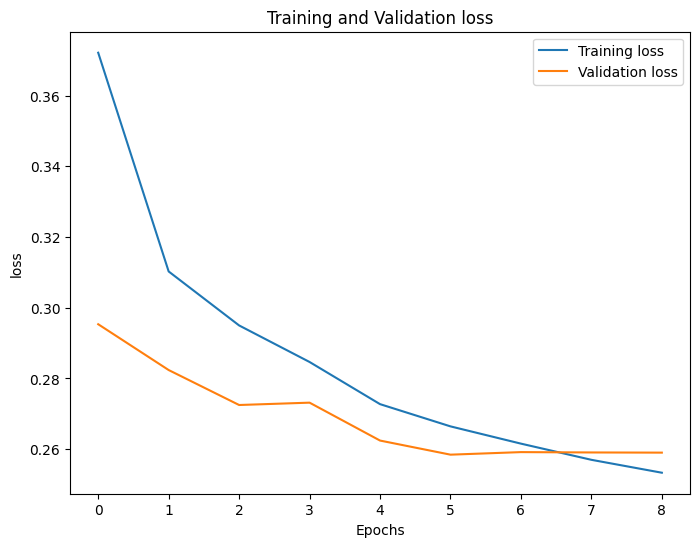

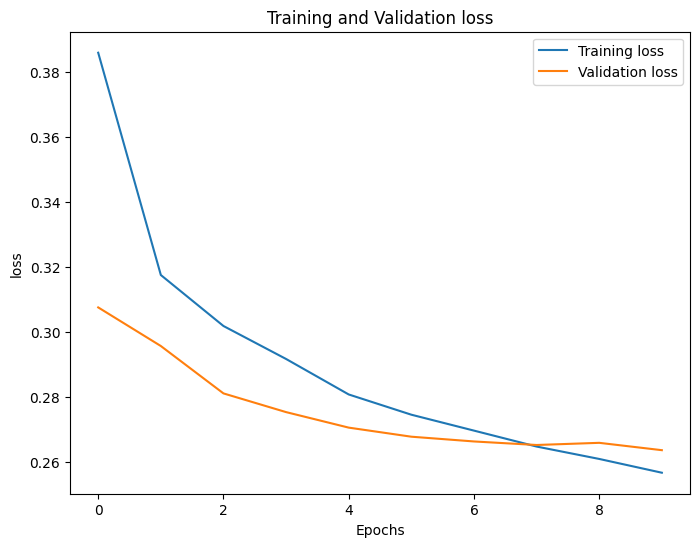

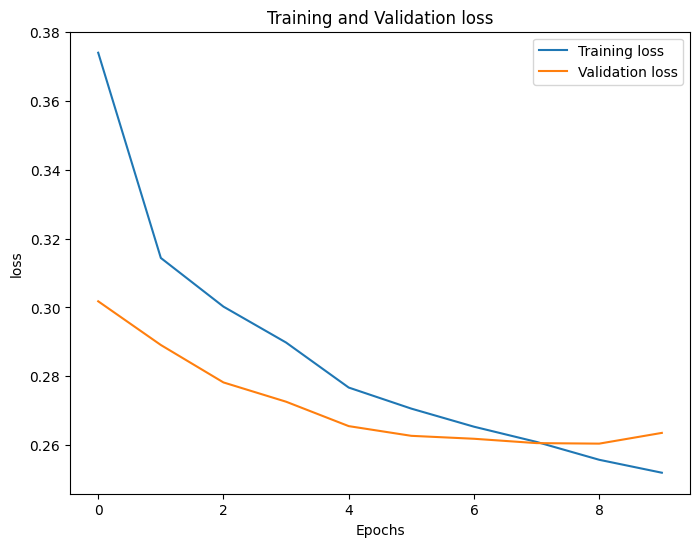

In [90]:
# Plot training history for accuracy
plot_training_history(history_lemmatized, 'accuracy')
plot_training_history(history_stemmed, 'accuracy')
plot_training_history(history_lemmatized_no_stopwords, 'accuracy')

# Plot training history for loss
plot_training_history(history_lemmatized, 'loss')
plot_training_history(history_stemmed, 'loss')
plot_training_history(history_lemmatized_no_stopwords, 'loss')

In [72]:
# Evaluate models
print("Evaluating models...")
acc_lemmatized, prec_lemmatized, rec_lemmatized, f1_lemmatized = evaluate_model(model_lemmatized, X_test_lemmatized, y_test)
acc_stemmed, prec_stemmed, rec_stemmed, f1_stemmed = evaluate_model(model_stemmed, X_test_stemmed, y_test)
acc_lemmatized_no_stopwords, prec_lemmatized_no_stopwords, rec_lemmatized_no_stopwords, f1_lemmatized_no_stopwords = evaluate_model(model_lemmatized_no_stopwords, X_test_lemmatized_no_stopwords, y_test)

# Print results
print("Results for Lemmatized Lyrics:")
print(f"Accuracy: {acc_lemmatized}, Precision: {prec_lemmatized}, Recall: {rec_lemmatized}, F1-score: {f1_lemmatized}")

print("Results for Stemmed Lyrics:")
print(f"Accuracy: {acc_stemmed}, Precision: {prec_stemmed}, Recall: {rec_stemmed}, F1-score: {f1_stemmed}")

print("Results for Lemmatized Lyrics without Stopwords:")
print(f"Accuracy: {acc_lemmatized_no_stopwords}, Precision: {prec_lemmatized_no_stopwords}, Recall: {rec_lemmatized_no_stopwords}, F1-score: {f1_lemmatized_no_stopwords}")

Evaluating models...
417/417 [==============================] - 7s 13ms/step
Results for Lemmatized Lyrics:
Accuracy: 0.4524095481158985, Precision: 0.7122840833271554, Recall: 0.5539348515422312, F1-score: 0.6232081468508789
Results for Stemmed Lyrics:
Accuracy: 0.4400240204173548, Precision: 0.710069049245011, Recall: 0.5395214759296627, F1-score: 0.6131568601755996
Results for Lemmatized Lyrics without Stopwords:
Accuracy: 0.4362708302056748, Precision: 0.7119696969696969, Recall: 0.5418276160276737, F1-score: 0.6153543951546897


In [73]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

def evaluate_multilabel_classification(model, X_test, y_true, threshold=0.5):
    # Predict probabilities
    y_pred_prob = model.predict(X_test)

    # Apply threshold to get binary predictions
    y_pred_binary = (y_pred_prob >= threshold).astype(int)

    # Compute multilabel confusion matrix
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_binary)

    return confusion_matrices

In [74]:
# Evaluate Lemmatized Lyrics
print("Results for Lemmatized Lyrics:")
cm_lemmatized = evaluate_multilabel_classification(model_lemmatized, X_test_lemmatized, y_test)

# Evaluate Stemmed Lyrics
print("Results for Stemmed Lyrics:")
cm_stemmed = evaluate_multilabel_classification(model_stemmed, X_test_stemmed, y_test)

# Evaluate Lemmatized Lyrics without Stopwords
print("Results for Lemmatized Lyrics without Stopwords:")
cm_lemmatized_no_stopwords = evaluate_multilabel_classification(model_lemmatized_no_stopwords, X_test_lemmatized_no_stopwords, y_test)


Results for Lemmatized Lyrics:
417/417 [==============================] - 6s 13ms/step
Results for Stemmed Lyrics:
417/417 [==============================] - 5s 13ms/step
Results for Lemmatized Lyrics without Stopwords:
417/417 [==============================] - 5s 13ms/step


In [75]:
cm_lemmatized

array([[[11588,   236],
        [  835,   663]],

       [[10859,   415],
        [  598,  1450]],

       [[10063,   803],
        [ 1295,  1161]],

       [[11117,   345],
        [  730,  1130]],

       [[10192,   342],
        [  998,  1790]],

       [[10237,   538],
        [ 1623,   924]],

       [[ 9818,   823],
        [ 1328,  1353]],

       [[11476,   379],
        [  330,  1137]]])

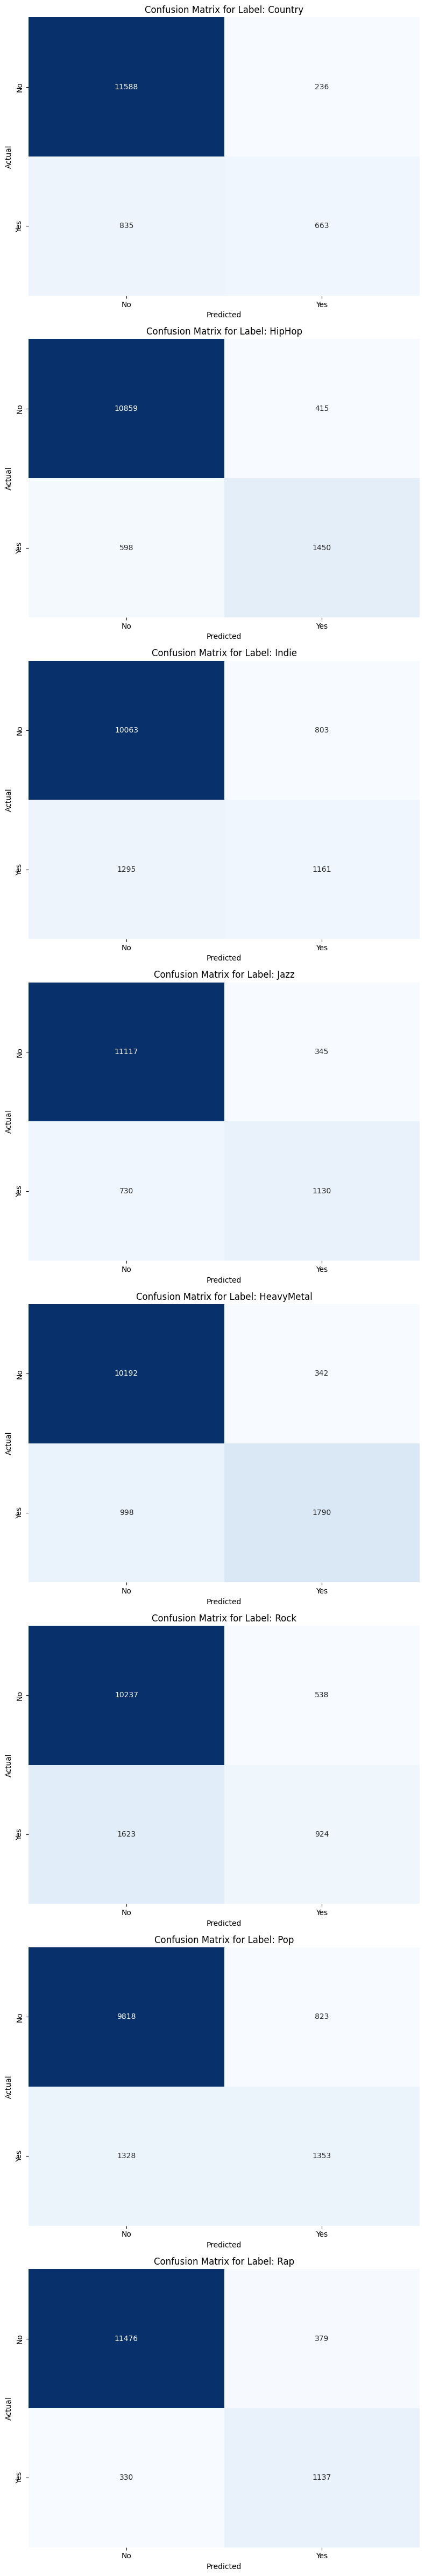

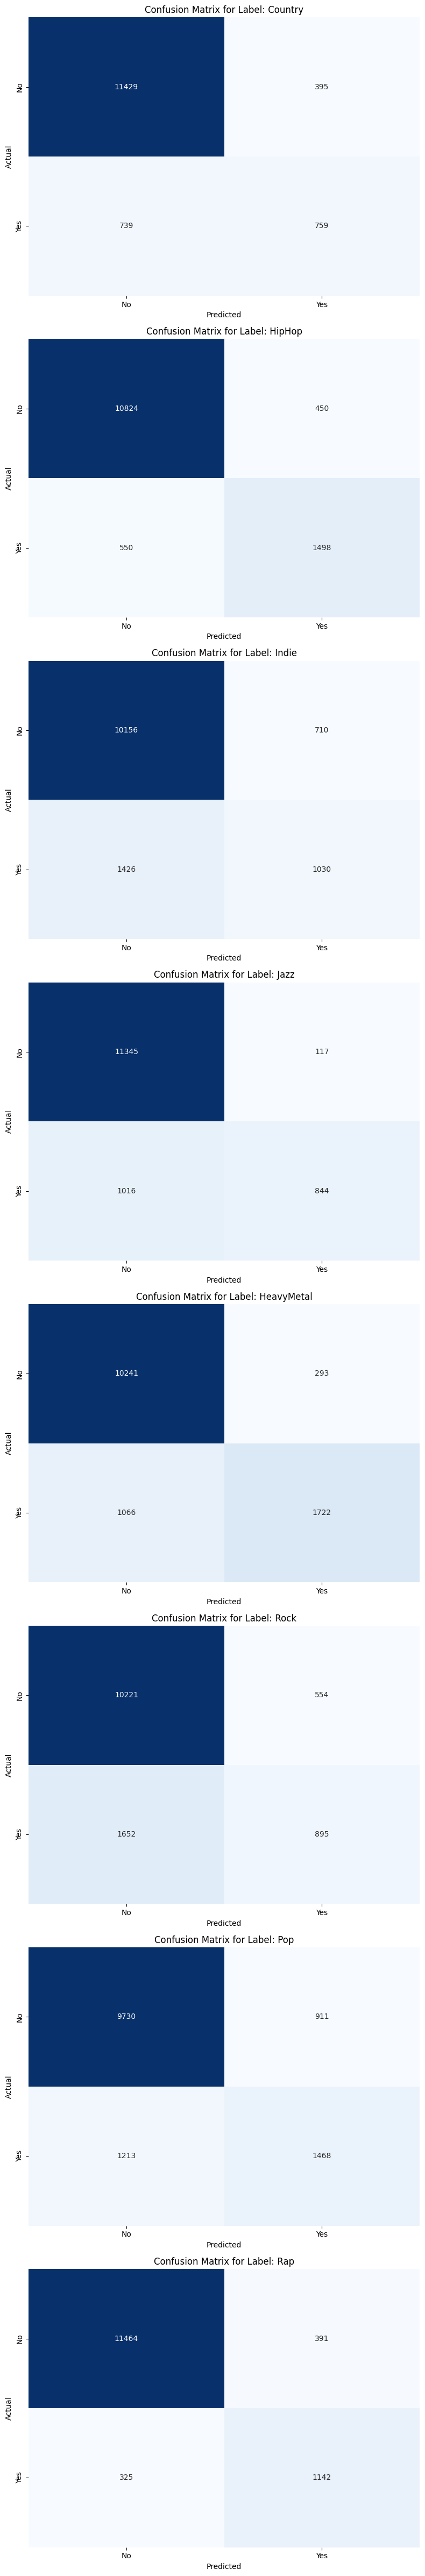

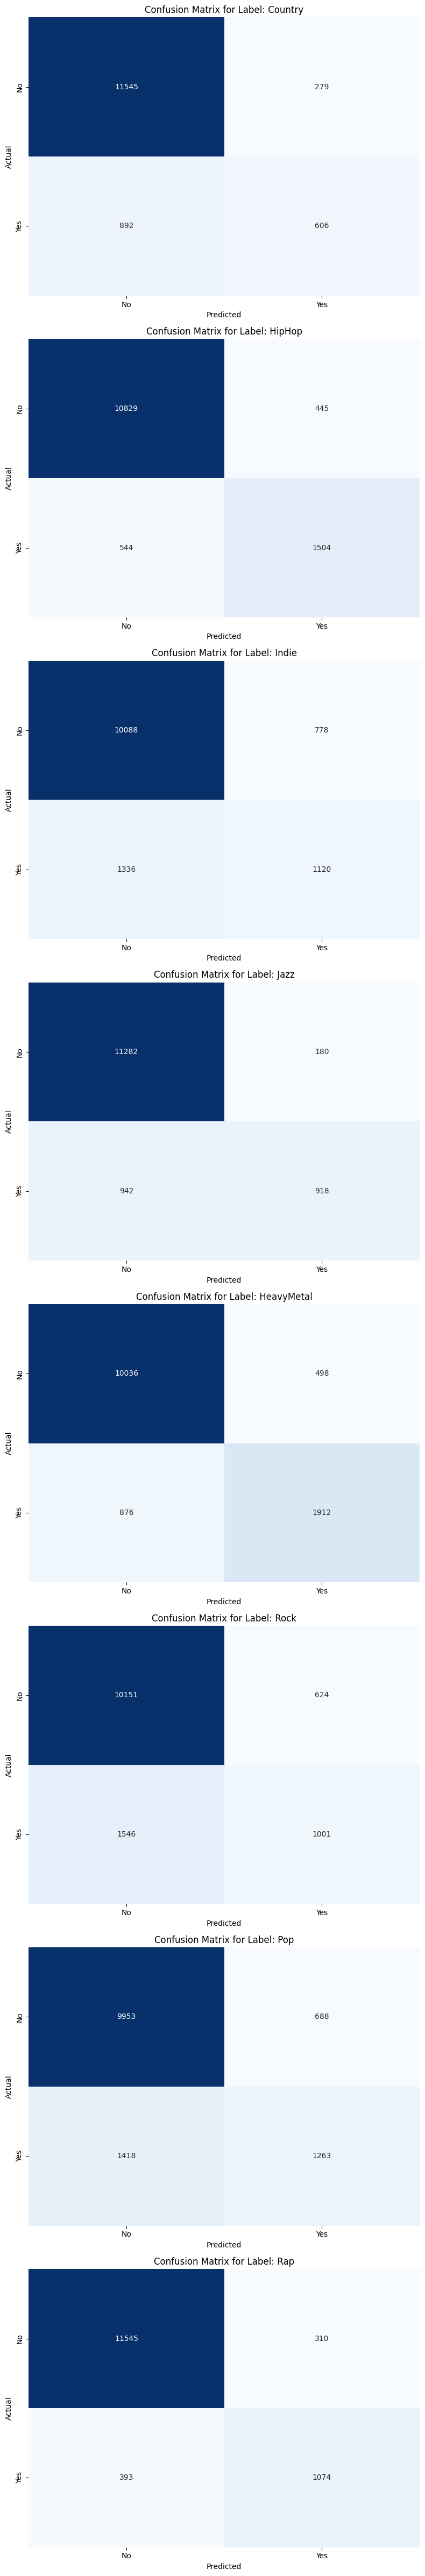

In [76]:
def plot_multilabel_confusion_matrix(cm, labels):
    num_labels = len(labels)
    fig, axes = plt.subplots(nrows=num_labels, ncols=1, figsize=(8, 6*num_labels))

    for i, (label, matrix) in enumerate(zip(labels, cm)):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for Label: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['No', 'Yes'])
        axes[i].set_yticklabels(['No', 'Yes'])

    plt.tight_layout()
    plt.show()

# Labels for each genre
LABEL_COLUMNS = ['Country', 'HipHop', 'Indie', 'Jazz', 'HeavyMetal', 'Rock', 'Pop', 'Rap']

# Plot confusion matrices for each model
plot_multilabel_confusion_matrix(cm_lemmatized, LABEL_COLUMNS)
plot_multilabel_confusion_matrix(cm_stemmed, LABEL_COLUMNS)
plot_multilabel_confusion_matrix(cm_lemmatized_no_stopwords, LABEL_COLUMNS)